# Task 2B - Find Likelihood to be Bad Actor

## Library and Pre-process

In [53]:
import pandas as pd
import numpy as np
import altair as alt
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import StratifiedKFold
from sklearn.metrics import accuracy_score, precision_score, recall_score, confusion_matrix

In [54]:
# Read main dataset
df = pd.read_csv('UofT_nodes.csv')
df_bad_list = pd.read_csv('0_final_badactors_list.csv')

In [55]:
# Change all to categorial
df['COUNTRY_RISK_INCOME'] = df['COUNTRY_RISK_INCOME'].astype('category').cat.codes
df['COUNTRY_RISK_RESIDENCY'] = df['COUNTRY_RISK_RESIDENCY'].astype('category').cat.codes
df['GENDER'] = df['GENDER'].astype('category').cat.codes

df['RISK'] = df['RISK'].replace(['low'], 0)
df['RISK'] = df['RISK'].replace(['medium'], 1)
df['RISK'] = df['RISK'].replace(['high'], 2)

In [56]:
# Convert Key(Customer ID) to int for join
df.CUSTOMER_ID = df.CUSTOMER_ID.astype(float).astype(int)
df_bad_list.CUSTOMER_ID = df_bad_list.CUSTOMER_ID.astype(float).astype(int)

# Change all date to date format
df.BIRTH_DT = pd.to_datetime(df.BIRTH_DT)
df.CUST_ADD_DT = pd.to_datetime(df.CUST_ADD_DT)

# Fill NaN with value different from the other
df.CUST_ADD_DT.fillna(pd.Timestamp('1800-01-01'), inplace=True)
df.OCPTN_NM.fillna(-1, inplace=True)

# Convert all dates to Unix timestamps for modeling
df['BIRTH_TS'] = df['BIRTH_DT'].apply(lambda x: x.timestamp())
df['CUST_ADD_TS'] = df['CUST_ADD_DT'].apply(lambda x: x.timestamp())
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1000000 entries, 0 to 999999
Data columns (total 22 columns):
 #   Column                  Non-Null Count    Dtype         
---  ------                  --------------    -----         
 0   BIRTH_DT                1000000 non-null  datetime64[ns]
 1   CUST_ADD_DT             1000000 non-null  datetime64[ns]
 2   OCPTN_NM                1000000 non-null  float64       
 3   RES_CNTRY_CA            1000000 non-null  int64         
 4   CNTRY_OF_INCOME_CA      1000000 non-null  int64         
 5   PEP_FL                  1000000 non-null  float64       
 6   CASH_SUM_IN             1000000 non-null  float64       
 7   CASH_CNT_IN             1000000 non-null  float64       
 8   CASH_SUM_OUT            1000000 non-null  float64       
 9   CASH_CNT_OUT            1000000 non-null  float64       
 10  WIRES_SUM_IN            1000000 non-null  float64       
 11  WIRES_CNT_IN            1000000 non-null  float64       
 12  WIRES_SUM_OUT  

In [57]:
df_bad_list.CUSTOMER_ID = df_bad_list.CUSTOMER_ID.astype(float).astype(int)
df_bad_list.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 50 entries, 0 to 49
Data columns (total 3 columns):
 #   Column       Non-Null Count  Dtype 
---  ------       --------------  ----- 
 0   Unnamed: 0   50 non-null     int64 
 1   NAME         50 non-null     object
 2   CUSTOMER_ID  50 non-null     int64 
dtypes: int64(2), object(1)
memory usage: 1.3+ KB


In [58]:
# Create bad actor label
df_bad_list['BAD_STATUS'] = [True]*df_bad_list.shape[0] # Create True labels for real bad actors 
df = df.merge(df_bad_list[['BAD_STATUS', 'CUSTOMER_ID']], on='CUSTOMER_ID', how='left') # Join
df.BAD_STATUS.fillna(False, inplace=True) # Fill the rest with False labels

In [59]:
# Check whether merged correctly
set(df_bad_list.CUSTOMER_ID) == set(df[df.BAD_STATUS].CUSTOMER_ID)

True

## Variable Selection

In [8]:
# Set variable will be used for training
column_feature = df.columns[2:16].to_list() + df.columns[20:22].to_list()

In [9]:
df[column_feature].dtypes

OCPTN_NM                  float64
RES_CNTRY_CA                int64
CNTRY_OF_INCOME_CA          int64
PEP_FL                    float64
CASH_SUM_IN               float64
CASH_CNT_IN               float64
CASH_SUM_OUT              float64
CASH_CNT_OUT              float64
WIRES_SUM_IN              float64
WIRES_CNT_IN              float64
WIRES_SUM_OUT             float64
WIRES_CNT_OUT             float64
COUNTRY_RISK_INCOME          int8
COUNTRY_RISK_RESIDENCY       int8
BIRTH_TS                  float64
CUST_ADD_TS               float64
dtype: object

In [10]:
# Split
X = df[column_feature]
y = df.BAD_STATUS

# Calculate the correlation between each feature and the target variable
corr = X.corrwith(y)

# Get the selected feature names
k = 10
indices = corr.abs().sort_values(ascending=False)[:k].index
selected_features = X[indices].columns.tolist()

In [11]:
selected_features

['COUNTRY_RISK_INCOME',
 'CNTRY_OF_INCOME_CA',
 'RES_CNTRY_CA',
 'CASH_SUM_IN',
 'COUNTRY_RISK_RESIDENCY',
 'CASH_CNT_IN',
 'WIRES_CNT_OUT',
 'CASH_CNT_OUT',
 'CASH_SUM_OUT',
 'WIRES_SUM_OUT']

## Modelling with Logistic Regression

In [12]:
# Remove feature names
X = X[selected_features].values

# Create a StratifiedKFold object with 5 folds (Avoid imbalanced issue)
skf = StratifiedKFold(n_splits=10, shuffle=True, random_state=7)
scaler = StandardScaler()

# Initialize an empty list to store the accuracy scores
acc_scores = []
prec_scores = []
rec_scores = []

for train_index, test_index in skf.split(X, y):
    # Split into training and testing sets
    X_train, X_test = X[train_index], X[test_index]
    y_train, y_test = y[train_index], y[test_index]
    
    # Normalize the training and testing data
    X_train_norm = scaler.fit_transform(X_train)
    X_test_norm = scaler.transform(X_test)
    
    # Initialize a LogisticRegression classifier
    lr = LogisticRegression(class_weight='balanced', random_state=7)
    
    # Train with the normalized training data
    lr.fit(X_train_norm, y_train)
    
    # Evaluate the normalized testing data
    y_pred = lr.predict(X_test)
    accuracy = accuracy_score(y_test, y_pred)
    precison = precision_score(y_test, y_pred, average='weighted')
    recall = recall_score(y_test, y_pred, average='weighted')

    acc_scores.append(accuracy)
    prec_scores.append(precison)
    rec_scores.append(recall)

print('Average accuracy:', np.mean(acc_scores))
print('Average precision:', np.mean(prec_scores))
print('Average recall:', np.mean(rec_scores))

Average accuracy: 0.9567309999999999
Average precision: 0.9999101076987091
Average recall: 0.9567309999999999


In [13]:
# Get the whole X back
X_all_norm = scaler.transform(df[selected_features].values)
bad_score = lr.predict_proba(X_all_norm) # This is the final likelihood to be a bad actor

In [14]:
# This is the final likelihood to be a bad actor
bad_score

array([[0.69436671, 0.30563329],
       [0.62090629, 0.37909371],
       [0.68111191, 0.31888809],
       ...,
       [0.41975386, 0.58024614],
       [0.2782785 , 0.7217215 ],
       [0.00386269, 0.99613731]])

## Visualization

In [60]:
# Groupby the bad actor label
bad_count = df.groupby('BAD_STATUS').count().BIRTH_DT.reset_index()
bad_count.rename(columns={'BAD_STATUS':'Bad Actor', 'BIRTH_DT':'Count'}, inplace=True)
bad_count['Percent'] = bad_count.Count/sum(bad_count.Count)
bad_count

,Bad Actor,Count,Percent
0,False,999950,0.99995
1,True,50,0.00005


In [16]:
# Create the chart
chart = alt.Chart(bad_count).mark_arc().encode(
    theta='Count:Q',
    color='Bad Actor:N'
).properties(
    width=300,
    height=300,
    title='Imbalanced Bad Actor Data'
)

# Add labels to the chart
labels = chart.mark_text(radius=140, size=12).encode(text=alt.Text('Percent:Q', format='.4%'))


# Show the chart
chart = chart + labels
chart

alt.LayerChart(...)

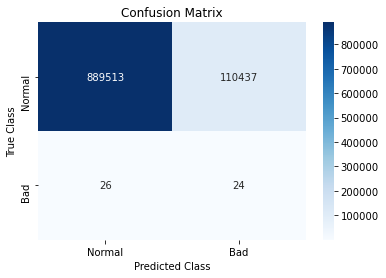

In [61]:
# y_true: the true class labels
# y_pred: the predicted class labels
y_true = df.BAD_STATUS
y_pred = (lr.predict_proba(X_all_norm)[:,1] >= 0.5).astype(bool) # can change threshold
cm = confusion_matrix(y_true, y_pred)

# Define class labels
class_names = ['Normal', 'Bad']

# Create a heatmap of the confusion matrix
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=class_names, yticklabels=class_names)

# Add labels to the plot
plt.title('Confusion Matrix')
plt.xlabel('Predicted Class')
plt.ylabel('True Class')
plt.show()